In [21]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)
from jwst.assign_wcs import nirspec
from jwst import datamodels

numpy version:  1.12.1
astropy version:  3.1.dev21607
asdf version:  2.0.0.dev1248
gwcs version:  0.9.dev323
jwst version:  0.9.2a.dev104 /internal/1/astropy/jwst/jwst/__init__.py


In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

In [23]:
!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg nrs1_fs.fits

2018-03-29 13:49:57,629 - stpipe.assign_wcs - INFO - AssignWcsStep instance created.
2018-03-29 13:49:57,653 - stpipe.assign_wcs - INFO - Step assign_wcs running with args ('nrs1_fs.fits',).
2018-03-29 13:49:58,465 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.1260581910610199 deg
2018-03-29 13:49:58,465 - stpipe.assign_wcs - INFO - gwa_xtilt is 0.3316612243652344 deg
2018-03-29 13:49:58,466 - stpipe.assign_wcs - INFO - theta_y correction: 0.0002496099796717191 deg
2018-03-29 13:49:58,467 - stpipe.assign_wcs - INFO - theta_x correction: 0.0 deg
2018-03-29 13:49:59,104 - stpipe.assign_wcs - INFO - Removing slit S200B1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2018-03-29 13:49:59,104 - stpipe.assign_wcs - INFO - Slits projected on detector NRS1: ['S200A1', 'S200A2', 'S400A1', 'S1600A1']
2018-03-29 13:49:59,105 - stpipe.assign_wcs - INFO - Computing WCS for 4 open slitlets
2018-03-29 13:49:59,148 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.

In [24]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")
esa.remove("esa/Trace_SLIT_B_200_V84600010001P0000000002101_39547_JLAB88.fits")
map_slit_names = {'SLIT_A_1600' : 'S1600A1',
                  'SLIT_A_200_1': 'S200A1',
                  'SLIT_A_200_2': 'S200A2',
                  'SLIT_A_400':   'S400A1',
                  }

In [25]:
im = datamodels.ImageModel('nrs1_fs_assign_wcs.fits')

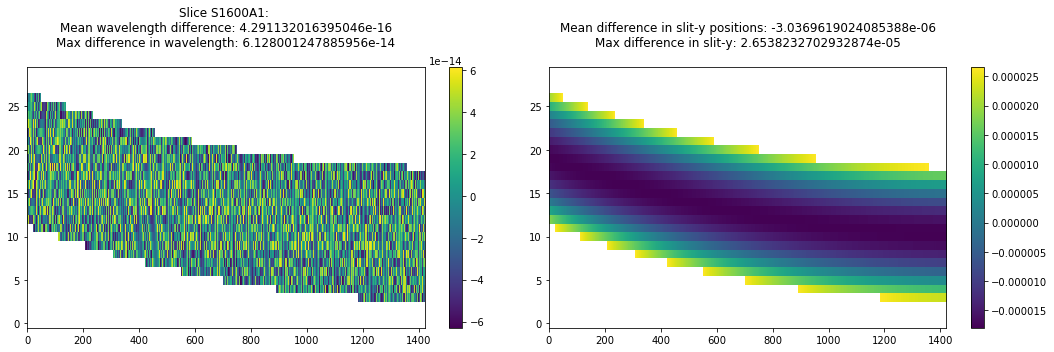

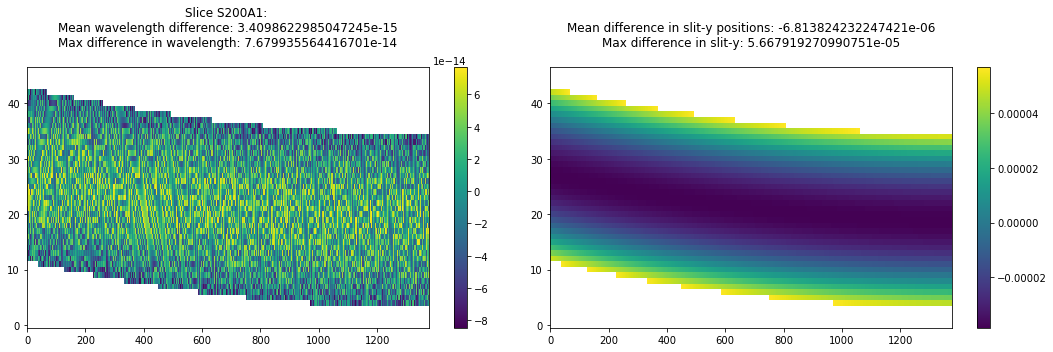

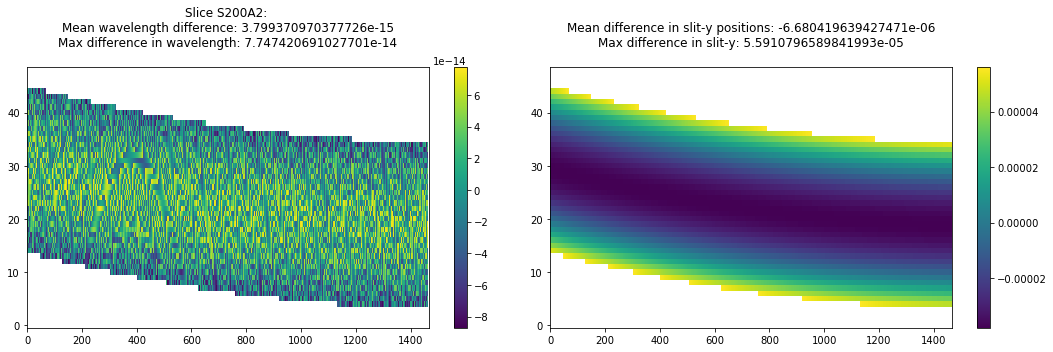

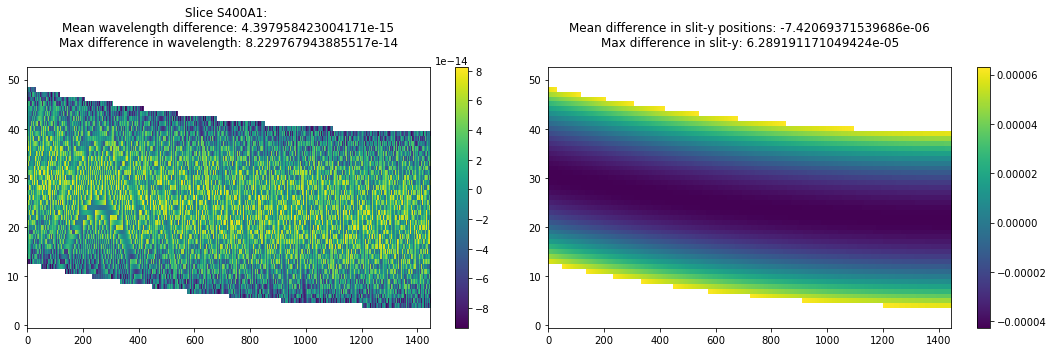

In [28]:
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr[4].data
    slit1 = tr[5].data
    msay1 = tr[7].data
    pyw = wcs.WCS(tr[4].header)
    slice_id = map_slit_names[tr[0].header['SLITID']]
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x+1, y+1, 1) # +1 for 1-based inputs

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    # Compute ra, dec and lambda
    ra, dec, lam = wcs_slice(x1, y1)
    lam *= 10**-6

    # For pixels where lam == NaN, set the value to -1
    notnan = ~np.isnan(lam)
    #lam[nanind] = -1
    #lam1[nanind] = -1
    #oneind = lam1 == -1
    #lam[oneind] = -1

    # Compute the difference in wavelength
    ##diff = np.abs(lam1 - lam)
    diff = lam1 - lam
    title = "Slice {}: \n".format(slice_id)
    title += "Mean wavelength difference: {}\n".format(np.mean(diff[notnan]))
    title += "Max difference in wavelength: {}\n".format(np.max(diff[notnan]))

    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, _ = detector2slit(x1, y1)
    #sy[nanind] = -1
    #sy[oneind] = -1
    #slit1[nanind] = -1
    diffslit = sy - slit1
    # Plot differences and some statistics
    titles = "Mean difference in slit-y positions: {}\n".format(np.mean(diffslit[notnan]))
    titles += "Max difference in slit-y: {}\n".format(np.max(diffslit[notnan]))
    #print ("SLICE {}".format(slice_id))
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diff, aspect='auto')
    plt.title(title)
    plt.colorbar(i1, ax=ax1 )
    ax2 = plt.subplot(1,2,2)
    i2 = ax2.imshow(diffslit, aspect='auto')
    plt.title(titles)
    plt.colorbar(i2, ax=ax2)

    fig.tight_layout()

In [29]:
from jwst import datamodels
from jwst.assign_wcs.nirspec import nrs_wcs_set_input

pipeline_file = "nrs1_fs_assign_wcs.fits"
im = datamodels.open(pipeline_file)
print("Working on exposure type {0}".format(im.meta.exposure.type))
print("grating: {0}".format(im.meta.instrument.grating))
print("filter: {0}".format(im.meta.instrument.filter))
print("GWA tilt correction:")
print("gwa_ytilt is 0.1260581910610199 deg")
print("gwa_xtilt is 0.3316612243652344 deg")
print("Final disperser THETA_Y angle is 0.12630780104069161 deg")

print("theta_x correction: 0.0 deg")
print("theta_y correction: {0} arcsec".format(0.0002496099796717191 * 3600))
print("Theta_y correction in Trace file is {0}".format(fits.getval(esa[0], "THETAY")))

Working on exposure type NRS_FIXEDSLIT
grating: G140M
filter: F100LP
GWA tilt correction:
gwa_ytilt is 0.1260581910610199 deg
gwa_xtilt is 0.3316612243652344 deg
Final disperser THETA_Y angle is 0.12630780104069161 deg
theta_x correction: 0.0 deg
theta_y correction: 0.8985959268181888 arcsec
Theta_y correction in Trace file is 0.8985959268181887


In [30]:
import test_slits

### Test 1

For each Trace file:
- Compute the pixel indices (x, y) for values in the SLIT extension that are between -0.5 and 0.5 (within the slit).
- Get the wavelength values for these pixels from the LAM extension.
- Transfer these (x, y) to full frame coordinates using the FITS WCS in the Trace file.
- Evaluate the pipeline WCS passing these x, y as input to obtain ra, dec, lam from the pipeline code.
- Compute the difference between the ESA and pipeline wavelengths for these x, y pixels.

In [31]:
test_slits.test_fixed_slit(pipeline_file, esa)


Running test for slit S1600A1
Slit SLIT_A_1600
	 Max diff in wavelength:  6.29845767115e-14
	 Mean diff in wavelength:  2.8576312509e-14
	 Max diff along slit y-axis:  2.65187618993e-05
	 Max diff in MSA x coordinate:  0.0
	 Mean diff in MSA x coordinate:  0.0
	 Max diff in MSA y coordinate:  1.64943886748e-08
	 Mean diff in MSA y coordinate:  7.53311555959e-09

Running test for slit S200A1
Slit SLIT_A_200_1
	 Number of pixels with NaN values in the diff:  1
	 Number of pixels with values of <= 10**-13 in the diff:  43060
	 Max diff in wavelength:  8.46919830239e-14
	 Mean diff in wavelength:  3.04407402759e-14
	 Max diff along slit y-axis:  5.66791927099e-05
	 Max diff in MSA x coordinate:  0.0
	 Mean diff in MSA x coordinate:  0.0
	 Max diff in MSA y coordinate:  7.21480765439e-08
	 Mean diff in MSA y coordinate:  3.27581703612e-08

Running test for slit S200A2
Slit SLIT_A_200_2
	 Number of pixels with NaN values in the diff:  67
	 Number of pixels with values of <= 10**-13 in the d

### Test 2 - Wavelength 

For each slice:

- Take the lam extension and transform the indices to (x,y) coordinates using its WCS.
- Compute RA, DEC, lambda by evaluating the pipeline WCS object on these (x, y).
- Display the difference between the two wavelength arrays.

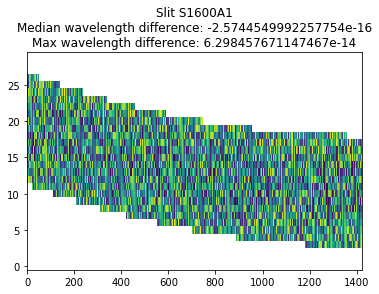

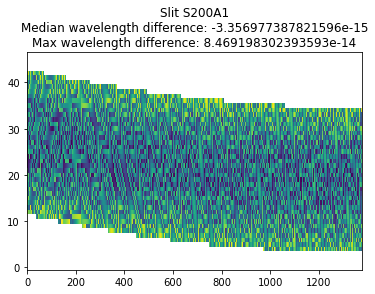

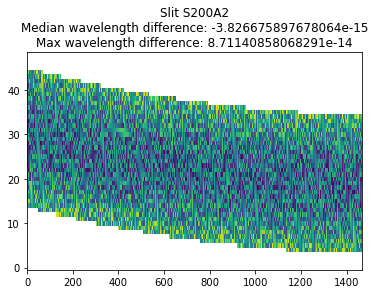

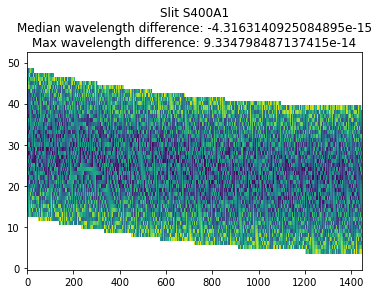

In [32]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    s = fits.getval(trace, 'SLITID')
    slit = test_slits.map_slit_names[s]
    # get the WCS object of this slice
    slice_w = nirspec.nrs_wcs_set_input(im, slit)

    diff = test_slits.test_wavelength(slice_w, trace)
    
    title = "Slit {0}".format(slit)
    title += "\nMedian wavelength difference: {0}".format(np.median(diff[~np.isnan(diff)]))
    title += "\nMax wavelength difference: {0}".format(np.abs(diff)[~np.isnan(diff)].max())
    plt.title(title)
    plt.imshow(diff, aspect='auto')
    plt.show()


### Test 3 - Y-slit position


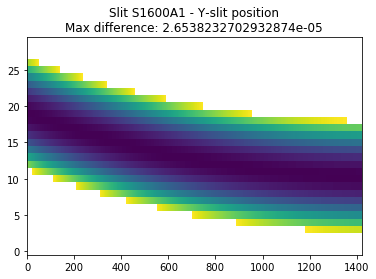

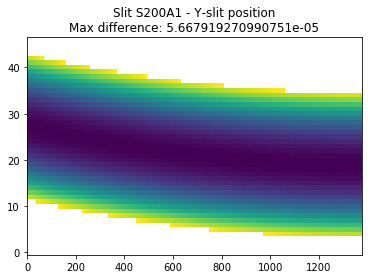

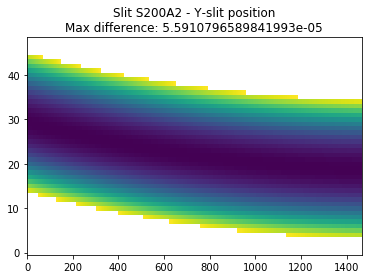

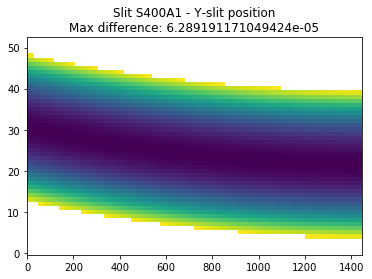

In [33]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    s = fits.getval(trace, 'SLITID')
    slit = test_slits.map_slit_names[s]
    # get the WCS object of this slice
    slice_w = nirspec.nrs_wcs_set_input(im, slit)

    diff = test_slits.test_yslit(slice_w, trace)
    
    title = "Slit {0} - Y-slit position".format(slit)
    title += "\nMax difference: {0}".format(np.abs(diff)[~np.isnan(diff)].max())
    plt.title(title)
    plt.imshow(diff, aspect='auto')
    plt.show()


### MSA_Y position

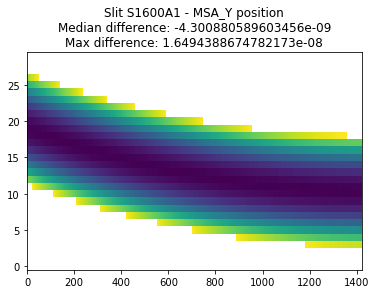

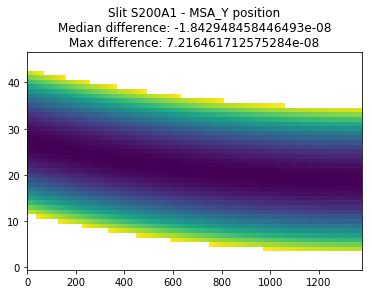

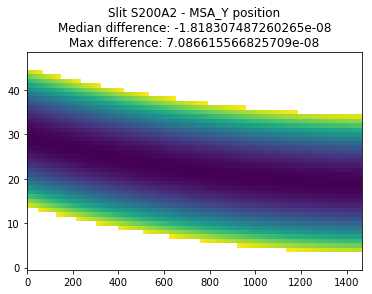

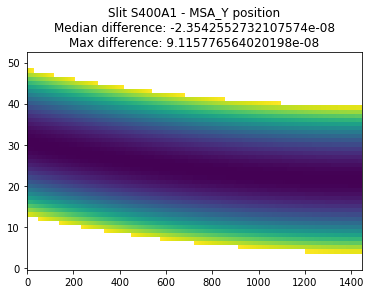

In [34]:
from jwst.assign_wcs import nirspec

# Open the file as a data model.
im = datamodels.ImageModel("nrs1_fs_assign_wcs.fits")
for trace in esa:
    s = fits.getval(trace, 'SLITID')
    slit = test_slits.map_slit_names[s]
    # get the WCS object of this slice
    slice_w = nirspec.nrs_wcs_set_input(im, slit)

    diff = test_slits.test_msay(slice_w, trace)
    
    title = "Slit {0} - MSA_Y position".format(slit)
    title += "\nMedian difference: {0}".format(np.median(diff[~np.isnan(diff)]))
    title += "\nMax difference: {0}".format(np.abs(diff)[~np.isnan(diff)].max())
    plt.title(title)
    plt.imshow(diff, aspect='auto')
    plt.show()
